## 8. Deep Learning on CIFAR10

### a.
*Exercise: Build a DNN with 20 hidden layers of 100 neurons each (that's too many, but it's the point of this exercise). Use He initialization and the ELU activation function.*

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

2023-12-10 13:57:26.804759: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/Adit/codes/ml_101/handson-ml2-master/ml_env/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 activation="elu",
                                 kernel_initializer="he_normal"))

### b.
*Exercise: Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with `keras.datasets.cifar10.load_data()`. The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you'll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model's architecture or hyperparameters.*

In [3]:
model.add(keras.layers.Dense(10, activation="softmax"))

Let's use a Nadam optimizer with a learning rate of 5e-5. I tried learning rates 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3 and 1e-2, and I compared their learning curves for 10 epochs each (using the TensorBoard callback, below). The learning rates 3e-5 and 1e-4 were pretty good, so I tried 5e-5, which turned out to be slightly better.

In [18]:
optimizer = keras.optimizers.Nadam(learning_rate=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=['accuracy'])

Let's load the CIFAR10 dataset. We also want to use early stopping, so we need a validation set. Let's use the first 5,000 images of the original training set as the validation set:

In [19]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

Now we can create the callbacks we need and train the model:

In [20]:
import os

In [21]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model.h5", save_best_only=True)
run_index = 1 # increment every time when we train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [22]:
%tensorboard --logdir=./my_cifar10_logs --port=6006

UsageError: Line magic function `%tensorboard` not found.


In [23]:
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 20s 10ms/step - loss: 1.5682 - accuracy: 0.4366 - val_loss: 1.7614 - val_accuracy: 0.3766
Epoch 2/100
  12/1407 [..............................] - ETA: 13s - loss: 1.6323 - accuracy: 0.3828

/Users/Adit/codes/ml_101/handson-ml2-master/ml_env/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1407/1407 [==============================] - 13s 9ms/step - loss: 1.5457 - accuracy: 0.4427 - val_loss: 1.7883 - val_accuracy: 0.3772
Epoch 3/100
1407/1407 [==============================] - 13s 9ms/step - loss: 1.5321 - accuracy: 0.4489 - val_loss: 1.7436 - val_accuracy: 0.3952
Epoch 4/100
1407/1407 [==============================] - 13s 9ms/step - loss: 1.5142 - accuracy: 0.4554 - val_loss: 1.6745 - val_accuracy: 0.4138
Epoch 5/100
1407/1407 [==============================] - 13s 9ms/step - loss: 1.4938 - accuracy: 0.4630 - val_loss: 1.6120 - val_accuracy: 0.4264
Epoch 6/100
1407/1407 [==============================] - 13s 9ms/step - loss: 1.4805 - accuracy: 0.4696 - val_loss: 1.6112 - val_accuracy: 0.4376
Epoch 7/100
1407/1407 [==============================] - 13s 10ms/step - loss: 1.4632 - accuracy: 0.4758 - val_loss: 1.6487 - val_accuracy: 0.4210
Epoch 8/100
1407/1407 [==============================] - 13s 10ms/step - loss: 1.4489 - accuracy: 0.4808 - val_loss: 1.5295 - val_accur

In [24]:
model = keras.models.load_model("my_cifar10_model.h5")
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 1s 3ms/step - loss: 1.4958 - accuracy: 0.4790


[1.495756983757019, 0.4790000021457672]

The model with the lowest validation loss gets about 47.6% accuracy on the validation set. It took 27 epochs to reach the lowest validation loss, with roughly 8 seconds per epoch on my laptop (without a GPU). Let's see if we can improve performance using Batch Normalization.

### c.
*Exercise: Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?*

The code below is very similar to the code above, with a few changes:

* I added a BN layer after every Dense layer (before the activation function), except for the output layer. I also added a BN layer before the first hidden layer.
* I changed the learning rate to 5e-4. I experimented with 1e-5, 3e-5, 5e-5, 1e-4, 3e-4, 5e-4, 1e-3 and 3e-3, and I chose the one with the best validation performance after 20 epochs.
* I renamed the run directories to run_bn_* and the model file name to my_cifar10_bn_model.h5.

In [25]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("elu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=['accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_bn_model.h5", save_best_only=True)
run_index = 1 # increment every time when we train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_bn_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_bn_model.h5")
model.evaluate(X_valid, y_valid)

Epoch 1/100
1406/1407 [============================>.] - ETA: 0s - loss: 1.8377 - accuracy: 0.3408

/Users/Adit/codes/ml_101/handson-ml2-master/ml_env/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1407/1407 [==============================] - 39s 17ms/step - loss: 1.8377 - accuracy: 0.3408 - val_loss: 1.6608 - val_accuracy: 0.4044
Epoch 2/100
1407/1407 [==============================] - 24s 17ms/step - loss: 1.6691 - accuracy: 0.4023 - val_loss: 1.5613 - val_accuracy: 0.4414
Epoch 3/100
1407/1407 [==============================] - 23s 17ms/step - loss: 1.5984 - accuracy: 0.4330 - val_loss: 1.5350 - val_accuracy: 0.4504
Epoch 4/100
1407/1407 [==============================] - 24s 17ms/step - loss: 1.5506 - accuracy: 0.4509 - val_loss: 1.5057 - val_accuracy: 0.4702
Epoch 5/100
1407/1407 [==============================] - 24s 17ms/step - loss: 1.5077 - accuracy: 0.4654 - val_loss: 1.4454 - val_accuracy: 0.4942
Epoch 6/100
1407/1407 [==============================] - 24s 17ms/step - loss: 1.4737 - accuracy: 0.4781 - val_loss: 1.4214 - val_accuracy: 0.4968
Epoch 7/100
1407/1407 [==============================] - 26s 19ms/step - loss: 1.4372 - accuracy: 0.4913 - val_loss: 1.4253 - val_

[1.310655117034912, 0.550599992275238]

* *Is the model converging faster than before?* Much faster! The previous model took 27 epochs to reach the lowest validation loss, while the new model achieved that same loss in just 5 epochs and continued to make progress until the 16th epoch. The BN layers stabilized training and allowed us to use a much larger learning rate, so convergence was faster.
* *Does BN produce a better model?* Yes! The final model is also much better, with 54.0% accuracy instead of 47.6%. It's still not a very good model, but at least it's much better than before (a Convolutional Neural Network would do much better, but that's a different topic, see chapter 14).
* *How does BN affect training speed?* Although the model converged much faster, each epoch took about 12s instead of 8s, because of the extra computations required by the BN layers. But overall the training time (wall time) was shortened significantly!

### d.
*Exercise: Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).*

In [29]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
#model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=['accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_selu_model.h5", save_best_only=True)
run_index = 1 # increment every time when we train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_selu_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 [==============================] - 20s 10ms/step - loss: 1.8996 - accuracy: 0.3196 - val_loss: 1.7557 - val_accuracy: 0.3836
Epoch 2/100
   6/1407 [..............................] - ETA: 14s - loss: 1.7794 - accuracy: 0.3281

/Users/Adit/codes/ml_101/handson-ml2-master/ml_env/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1407/1407 [==============================] - 14s 10ms/step - loss: 1.6904 - accuracy: 0.3998 - val_loss: 1.6670 - val_accuracy: 0.4014
Epoch 3/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.5989 - accuracy: 0.4358 - val_loss: 1.6164 - val_accuracy: 0.4124
Epoch 4/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.5379 - accuracy: 0.4596 - val_loss: 1.6203 - val_accuracy: 0.4394
Epoch 5/100
1407/1407 [==============================] - 15s 10ms/step - loss: 1.4790 - accuracy: 0.4826 - val_loss: 1.5297 - val_accuracy: 0.4664
Epoch 6/100
1407/1407 [==============================] - 15s 10ms/step - loss: 1.4362 - accuracy: 0.4992 - val_loss: 1.5138 - val_accuracy: 0.4794
Epoch 7/100
1407/1407 [==============================] - 15s 11ms/step - loss: 1.3951 - accuracy: 0.5146 - val_loss: 1.5207 - val_accuracy: 0.4738
Epoch 8/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.3606 - accuracy: 0.5241 - val_loss: 1.4911 - val_

[1.477542519569397, 0.5031999945640564]

In [30]:
model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate(X_valid_scaled, y_valid)

157/157 [==============================] - 1s 4ms/step - loss: 1.4775 - accuracy: 0.5032


[1.477542519569397, 0.5031999945640564]

We get 50.3% accuracy, which is not much better than the original model, and not as good as the model using batch normalization (55.0%). However, convergence was almost as fast as with the BN model, plus each epoch took only 7 seconds. So it's by far the fastest model to train so far.

### e.
*Exercise: Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.*

In [31]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=['accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_alpha_dropout_model.h5", save_best_only=True)
run_index = 1 # increment every time when we train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_alpha_dropout_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_alpha_dropout_model.h5")
model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 [==============================] - 21s 11ms/step - loss: 1.8936 - accuracy: 0.3238 - val_loss: 1.7366 - val_accuracy: 0.3912
Epoch 2/100
   1/1407 [..............................] - ETA: 17s - loss: 1.8313 - accuracy: 0.3438

/Users/Adit/codes/ml_101/handson-ml2-master/ml_env/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1407/1407 [==============================] - 16s 11ms/step - loss: 1.6652 - accuracy: 0.4126 - val_loss: 1.6834 - val_accuracy: 0.4086
Epoch 3/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.5816 - accuracy: 0.4478 - val_loss: 1.6089 - val_accuracy: 0.4330
Epoch 4/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.5124 - accuracy: 0.4676 - val_loss: 1.6012 - val_accuracy: 0.4506
Epoch 5/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.4597 - accuracy: 0.4891 - val_loss: 1.5535 - val_accuracy: 0.4718
Epoch 6/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.4078 - accuracy: 0.5086 - val_loss: 1.5098 - val_accuracy: 0.4908
Epoch 7/100
1407/1407 [==============================] - 16s 12ms/step - loss: 1.3649 - accuracy: 0.5221 - val_loss: 1.5923 - val_accuracy: 0.4688
Epoch 8/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.3255 - accuracy: 0.5382 - val_loss: 1.5350 - val_

[1.509841799736023, 0.49079999327659607]

The model reaches 49.0% accuracy on the validation set. That's very slightly better than without dropout (47.6%). With an extensive hyperparameter search, it might be possible to do better (I tried dropout rates of 5%, 10%, 20% and 40%, and learning rates 1e-4, 3e-4, 5e-4, and 1e-3), but probably not much better in this case.

Let's use MC Dropout now. We will need the `MCAlphaDropout` class we used earlier, so let's just copy it here for convenience:

In [35]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

Now let's create a new model, identical to the one we just trained (with the same weights), but with `MCAlphaDropout` dropout layers instead of `AlphaDropout` layers:

In [36]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

Then let's add a couple utility functions. 

The first will run the model many times (10 by default) and it will return the mean predicted class probabilities. 

The second will use these mean probabilities to predict the most likely class for each instance:

In [39]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)

Now let's make predictions for all the instances in the validation set, and compute the accuracy:

In [40]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = np.mean(y_pred == y_valid[:, 0])
accuracy

157/157 [==============================] - 1s 4ms/step


0.491

We get no accuracy improvement in this case (we're still at 48.9% accuracy).

So the best model we got in this exercise is the Batch Normalization model.

### f.
*Exercise: Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.*

In [41]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=['accuracy'])

In [66]:
import math
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

352/352 [==============================] - 14s 40ms/step - loss: nan - accuracy: 0.4889


(9.999999747378752e-06,
 9.615227699279785,
 0.8319306969642639,
 1.2571042350360326)

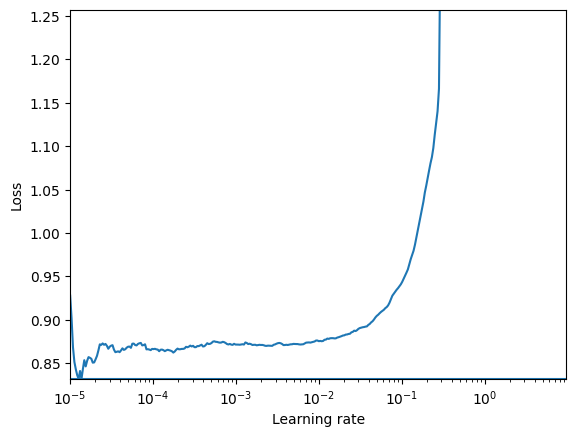

In [69]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

In [58]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=['accuracy'])

In [60]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [61]:
n_epochs = 15
onecycle = OneCycleScheduler(math.ceil(len(X_train_scaled) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/15
352/352 [==============================] - 10s 20ms/step - loss: 2.0527 - accuracy: 0.2809 - val_loss: 1.7548 - val_accuracy: 0.3686
Epoch 2/15
352/352 [==============================] - 12s 33ms/step - loss: 1.7595 - accuracy: 0.3752 - val_loss: 1.6625 - val_accuracy: 0.4142
Epoch 3/15
352/352 [==============================] - 16s 45ms/step - loss: 1.6250 - accuracy: 0.4218 - val_loss: 1.6169 - val_accuracy: 0.4280
Epoch 4/15
352/352 [==============================] - 14s 39ms/step - loss: 1.5487 - accuracy: 0.4498 - val_loss: 1.6379 - val_accuracy: 0.4264
Epoch 5/15
352/352 [==============================] - 13s 37ms/step - loss: 1.4979 - accuracy: 0.4690 - val_loss: 1.6878 - val_accuracy: 0.4318
Epoch 6/15
352/352 [==============================] - 13s 37ms/step - loss: 1.4575 - accuracy: 0.4836 - val_loss: 1.5933 - val_accuracy: 0.4450
Epoch 7/15
352/352 [==============================] - 11s 33ms/step - loss: 1.4136 - accuracy: 0.4982 - val_loss: 1.6650 - val_accuracy:

One cycle allowed us to train the model in just 15 epochs, each taking only 2 seconds (thanks to the larger batch size). This is several times faster than the fastest model we trained so far. Moreover, we improved the model's performance (from 47.6% to 52.0%). The batch normalized model reaches a slightly better performance (54%), but it's much slower to train.